<a href="https://colab.research.google.com/github/sarcasticvibes/Transliteration-Hindi2English/blob/master/TransliterationHindi2English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methodology For performing Transliteration

---


>We are using ***detectron2*** to extract segments of image which have text by finding bounding boxes in the image that best capture the given segmen

 >These segments are later extracted and fed to ***CRNN*** for feature extraction and then intepreted into equivalent text which in this setup is in ***Hindi***
vernacular

>This extraced text is now fed to an ***Encoder - Decoder*** model which uses ***Attention*** to better capture the relation between the two languages (Hindi & English) and *Transliteration* is performed from the given Hindi text to English

---

I have decided to train all the three models independently and then combine them for the final inference

---




# About the Dataset

---
The dataset used was provided by PadhAI as a part of their final capstone project.


---



In [ ]:
! pip install albumentations --upgrade

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 634kB 11.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=5a6f1f5207015b98374ab7ad82522c2e00489b828e96f07344f345e0ddaeb6bf
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=c99a7ecfb15cd8cd634abc1658d47152c100d8060ea6625f4cc855a37caf59ca
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=8778ebc155ce867f7ec2b0412f2dfcaaddae28524a078d00b71a9bcf5a0d6389
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


# Importing Essential Libraries

---
All essential imports have been done in this section


---



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms 
from pretrainedmodels import resnet18

import numpy as np
import pandas as pd
import scipy
import os

import cv2
from PIL import Image
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow
import joblib
# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import train_test_split

In [ ]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [ ]:
! mkdir segment_pickles

## Downloading the training and testing datasets for this instance

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Downloading and Extracting Training Dataset

In [ ]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1oWpEz_074TmtGprZJdAabR5lqsOWxIj8'
downloaded = drive.CreateFile({'id': file_id})     #https://drive.google.com/open?id=1oWpEz_074TmtGprZJdAabR5lqsOWxIj8
downloaded.GetContentFile('Synthetic_Train_Set_DetectionRecognition.tar.7z')

In [ ]:
!apt-get install p7zip-full
!p7zip -d Synthetic_Train_Set_DetectionRecognition.tar.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 546195564 bytes (521 MiB)

Extracting archive: Synthetic_Train_Set_DetectionRecognition.tar.7z
--
Path = Synthetic_Train_Set_DetectionRecognition.tar.7z
Type = 7z
Physical Size = 546195564
Headers Size = 202
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - Synthetic Train Set - Detection & Recognition.tar

In [ ]:
!tar -xvf '/content/Synthetic Train Set - Detection & Recognition.tar'

## Downloading and Extracting Test Dataset

In [ ]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1gUeDW2GzF7tcztu8i81NDrnnR1bWWBkY'
downloaded = drive.CreateFile({'id': file_id})     #https://drive.google.com/open?id=1gUeDW2GzF7tcztu8i81NDrnnR1bWWBkY
downloaded.GetContentFile('real_Image_dataset_Detection.tar')

In [ ]:
!tar -xvf /content/real_Image_dataset_Detection.tar

In [ ]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1zn6XBk2bXRJmSKe2WlNBbZk6NPe00QxM'
downloaded = drive.CreateFile({'id': file_id})     #https://drive.google.com/open?id=1zn6XBk2bXRJmSKe2WlNBbZk6NPe00QxM
downloaded.GetContentFile('cropped_data.tar')

In [ ]:
!tar -xvf /content/cropped_data.tar

## Directory Setup for Datasets

In [ ]:
train_data_path = '/content/Synthetic Train Set - Detection & Recognition/'
detection_test_data_path='/content/real_Image_dataset_Detection/'
recognition_test_data_path='/content/cropped_data/'

# Detectron2 model

## Setting up ***Detectron2***

---


Using ***Detectron2*** for  *object* *detection* and *segmentation*


---












In [ ]:
# install dependencies
!pip install -U torch torchvision cython fvcore Pillow==6.2.2
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)
Requirement already up-to-date: Pillow==6.2.2 in /usr/local/lib/python3.6/dist-packages (6.2.2)
     |████████████████████████████████| 276kB 10.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200114-cp36-none-any.whl size=30376 sha256=ff6afd81ce909ee5efc0089cbc31b6abb0c4413399dc8f9264d27e15e3279b62
  Stored in directory: /root/.cache/pip/wheels/31/52/ce/158c59c47690d60a76878c7b09d3e660fbfb091acbc02e6da3
  Created wheel for pyyaml: filename=PyYAML-5.3-cp36-cp36m-linux_x86_64.whl size=44229 sha256=6c35b3612c4cb26dbf7af20fe104ba26d60ddb878a9c275dc5fce087d5890813
  Stored in directory: /root/.cache/pip/wheels/e4/76/4d/a95b8dd7b452b69e8ed4f68b69e1b55e12c9c9624dd962b191
Successfully built fvcore pyyaml
  Found ex

'1.3.1'

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 2415 (delta 7), reused 20 (delta 6), pack-reused 2374
Receiving objects: 100% (2415/2415), 1.87 MiB | 3.63 MiB/s, done.
Resolving deltas: 100% (1589/1589), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 61kB 3.6MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

## Dataloader 

---

Setting up dataloader for test and train set to train ***Detectron2***

---



In [ ]:
def get_train_dicts():
  dataset_dicts = []
  idx=0
  for i in range (1,26):
    for image_path in os.listdir(train_data_path+'Image/'+str(i)+'/'):
      record = {}
        
      filename = train_data_path+'Image/'+str(i)+'/'+image_path
      height, width = cv2.imread(filename).shape[:2]
      
      record["file_name"] = filename
      record["image_id"] = idx
      record["height"] = height
      record["width"] = width

      idx+=1
      objs = []

      with open(train_data_path+'Annotation/'+str(i)+'/'+image_path[:-3]+'txt',mode='r') as f:
        ground_truth=f.read()
        ground_truth=list(ground_truth.split('\n'))
        
        for anno in ground_truth:
            anno = anno.split()
            if(len(anno)!=9):
              continue
            #print(anno)
            px = anno[:4]
            px=[float(x) for x in px]
            py = anno[4:8]
            py=[float(x) for x in py]
            #print(px,py)
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(np.abs(px)), np.min(np.abs(py)), np.max(np.abs(px)), np.max(np.abs(py))],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
def get_test_dicts():
  dataset_dicts = []
  idx=0
  for image_path in os.listdir(detection_test_data_path+'Image/'):
    record = {}
      
    filename = detection_test_data_path+'Image/'+image_path
    height, width = cv2.imread(filename).shape[:2]
    
    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width

    idx+=1
    objs = []

    with open(detection_test_data_path+'Annotation/'+'/'+image_path[:-3]+'txt',mode='r') as f:
      ground_truth=f.read()
      ground_truth=list(ground_truth.split('\n'))
      
      for anno in ground_truth:
          anno = anno.split()
          if(len(anno)!=9):
            continue
          #print(anno)
          px = anno[:4]
          px=[float(x) for x in px]
          py = anno[4:8]
          py=[float(x) for x in py]
          #print(px,py)
          poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
          poly = [p for x in poly for p in x]

          obj = {
              "bbox": [np.min(np.abs(px)), np.min(np.abs(py)), np.max(np.abs(px)), np.max(np.abs(py))],
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": 0,
              "iscrowd": 0
          }
          objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
d="train"
DatasetCatalog.register("Hindi_Text_Recognition_trainingDataset", lambda d=d: get_train_dicts())
MetadataCatalog.get("Hindi_Text_Recognition_trainingDataset").set(thing_classes=["text"])
text_metadata = MetadataCatalog.get("Hindi_Text_Recognition_trainingDataset")

In [ ]:
d="val"
DatasetCatalog.register("Hindi_Text_Recognition_testDataset1", lambda d=d: get_test_dicts())
MetadataCatalog.get("Hindi_Text_Recognition_testDataset1").set(thing_classes=["text"])

Metadata(name='Hindi_Text_Recognition_testDataset1', thing_classes=['text'])

In [ ]:
test_dataset_dicts = get_test_dicts()

In [ ]:
for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=text_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
    print(d["image_id"])
    print(d["file_name"])

## Training ***Detectron2***

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Hindi_Text_Recognition_trainingDataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0002  # pick a good LR
cfg.SOLVER.MAX_ITER = 14980    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (text)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/13 02:27:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:18, 9.48MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[01/13 02:33:31 d2.engine.train_loop]: Starting training from iteration 0
[01/13 02:33:38 d2.utils.events]: eta: 1:23:47  iter: 19  total_loss: 1.815  loss_cls: 0.675  loss_box_reg: 0.052  loss_mask: 0.692  loss_rpn_cls: 0.328  loss_rpn_loc: 0.036  time: 0.3350  data_time: 0.0319  lr: 0.000004  max_mem: 2712M
[01/13 02:33:45 d2.utils.events]: eta: 1:24:12  iter: 39  total_loss: 1.772  loss_cls: 0.623  loss_box_reg: 0.081  loss_mask: 0.688  loss_rpn_cls: 0.338  loss_rpn_loc: 0.040  time: 0.3380  data_time: 0.0073  lr: 0.000008  max_mem: 2767M
[01/13 02:33:52 d2.utils.events]: eta: 1:24:42  iter: 59  total_loss: 1.678  loss_cls: 0.549  loss_box_reg: 0.101  loss_mask: 0.675  loss_rpn_cls: 0.276  loss_rpn_loc: 0.037  time: 0.3391  data_time: 0.0065  lr: 0.000012  max_mem: 2767M
[01/13 02:33:59 d2.utils.events]: eta: 1:24:35  iter: 79  total_loss: 1.537  loss_cls: 0.465  loss_box_reg: 0.147  loss_mask: 0.664  loss_rpn_cls: 0.207  loss_rpn_loc: 0.038  time: 0.3401  data_time: 0.0078  lr: 0.0

OrderedDict()

In [ ]:
cfg.SOLVER.BASE_LR = 0.0002
cfg.SOLVER.MAX_ITER = 15500
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[01/13 04:20:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

{}

In [ ]:
# Look at training curves in tensorboard:
!kill 5487
%load_ext tensorboard
%tensorboard --logdir output

/bin/bash: line 0: kill: (5487) - No such process


In [ ]:
cfg.MODEL.WEIGHTS = '/content/gdrive/My Drive/model_final_15500.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("Hindi_Text_Recognition_testDataset1", )
predictor = DefaultPredictor(cfg)

{'instances': Instances(num_instances=3, image_height=550, image_width=930, fields=[pred_boxes = Boxes(tensor([[282.8998, 373.9845, 586.0029, 524.9313],
        [151.1496, 356.1104, 190.1275, 385.9230],
        [536.3010,  45.7438, 576.7906,  99.6724]], device='cuda:0')), scores = tensor([0.9855, 0.7666, 0.7610], device='cuda:0'), pred_classes = tensor([0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False

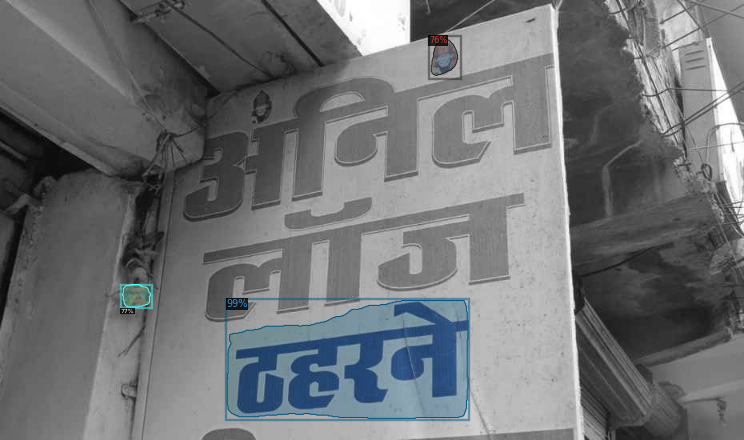

{'instances': Instances(num_instances=5, image_height=500, image_width=715, fields=[pred_boxes = Boxes(tensor([[374.4789, 255.8964, 618.0713, 348.9677],
        [425.4489,  92.4523, 681.1996, 224.6884],
        [  2.1466,  90.2374, 314.3559, 223.4796],
        [ 43.5828, 240.3778, 333.7007, 344.7101],
        [ 50.3864, 243.7768, 115.8661, 338.5067]], device='cuda:0')), scores = tensor([0.9976, 0.9973, 0.9970, 0.9918, 0.8966], device='cuda:0'), pred_classes = tensor([0, 0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, F

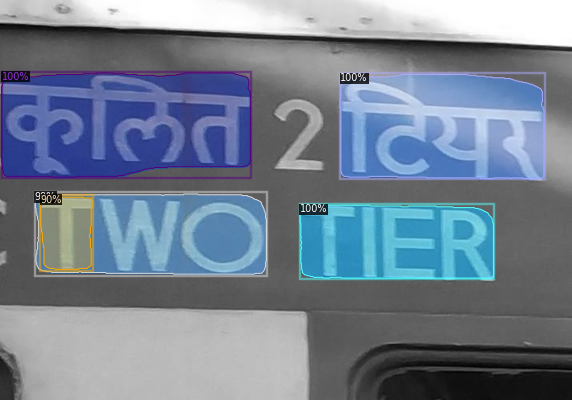

{'instances': Instances(num_instances=6, image_height=500, image_width=715, fields=[pred_boxes = Boxes(tensor([[  2.3489, 219.3467,  82.0380, 265.6840],
        [462.5867,  79.8398, 705.1647, 198.4264],
        [311.8481, 238.1531, 557.8784, 392.1497],
        [248.7126, 152.1122, 413.3505, 223.7543],
        [ 63.4761, 261.1832, 302.4431, 409.2681],
        [ 86.7099, 185.8001, 243.5800, 250.0543]], device='cuda:0')), scores = tensor([0.9968, 0.9954, 0.9921, 0.9908, 0.9899, 0.9873], device='cuda:0'), pred_classes = tensor([0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False,

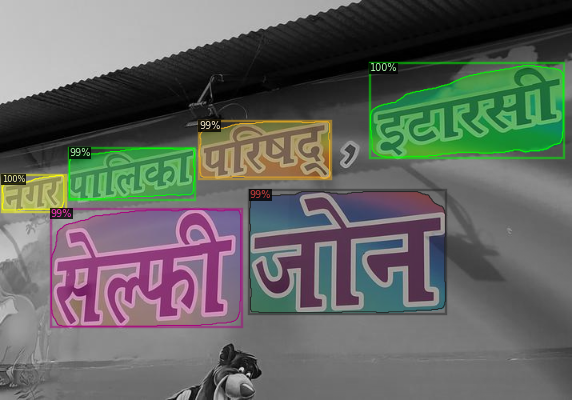

{'instances': Instances(num_instances=8, image_height=430, image_width=715, fields=[pred_boxes = Boxes(tensor([[304.5607,   4.0330, 473.2855, 138.9722],
        [566.9564,  59.3874, 634.3289, 155.5040],
        [466.7071,   5.9879, 582.3522,  87.8071],
        [305.8729, 246.6613, 344.1720, 282.5152],
        [538.4324, 281.3003, 592.1094, 336.1293],
        [409.9801, 329.3121, 441.7027, 359.5168],
        [316.9230, 263.7569, 406.9516, 351.3380],
        [288.7764, 155.3244, 321.6051, 188.8132]], device='cuda:0')), scores = tensor([0.9786, 0.9327, 0.8576, 0.8324, 0.8190, 0.7439, 0.6675, 0.5836],
       device='cuda:0'), pred_classes = tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., Fals

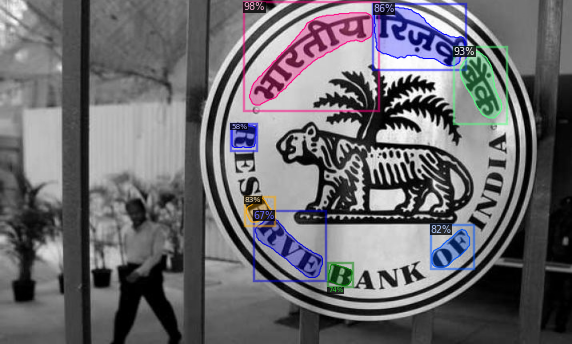

{'instances': Instances(num_instances=6, image_height=500, image_width=715, fields=[pred_boxes = Boxes(tensor([[ 48.3877, 155.9199, 256.5912, 220.1607],
        [ 47.5378, 312.8662, 278.3702, 387.6517],
        [ 44.0339,  71.9092, 377.7526, 144.3747],
        [ 47.3680, 235.5573, 302.7730, 303.5569],
        [644.8663,  29.2831, 682.5513,  86.6554],
        [609.0278, 316.7109, 661.1361, 346.4188]], device='cuda:0')), scores = tensor([0.9985, 0.9969, 0.9937, 0.9917, 0.8904, 0.8312], device='cuda:0'), pred_classes = tensor([0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False,

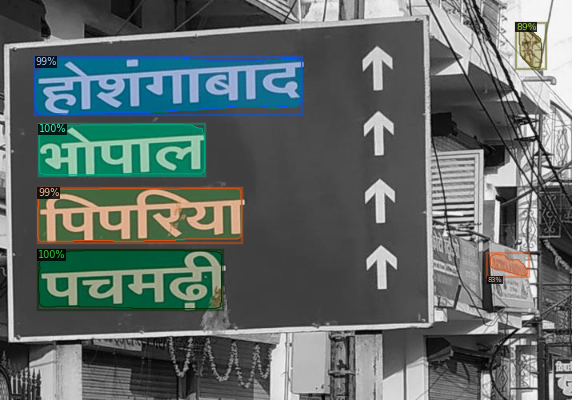

{'instances': Instances(num_instances=10, image_height=500, image_width=715, fields=[pred_boxes = Boxes(tensor([[211.7365, 344.4498, 344.6008, 386.1934],
        [363.0751, 342.0819, 521.8399, 373.8330],
        [381.0657, 453.6496, 474.4627, 477.8306],
        [251.9164, 454.8005, 369.6650, 479.3219],
        [294.3776, 257.2331, 419.0060, 278.4288],
        [377.8634, 461.0537, 416.6167, 477.8659],
        [288.3098, 255.7310, 322.5223, 278.9446],
        [321.6245, 453.5551, 369.8405, 479.3471],
        [443.2752, 428.5708, 529.3792, 448.3617],
        [378.4755, 261.1823, 419.9596, 276.4916]], device='cuda:0')), scores = tensor([0.9963, 0.9959, 0.9909, 0.9903, 0.9798, 0.9650, 0.9407, 0.8536, 0.7294,
        0.5270], device='cuda:0'), pred_classes = tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False

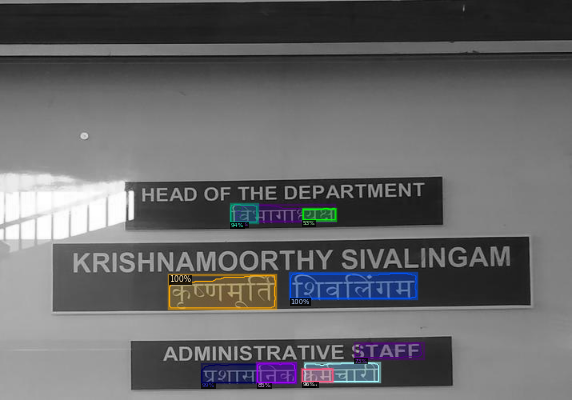

{'instances': Instances(num_instances=4, image_height=500, image_width=715, fields=[pred_boxes = Boxes(tensor([[ 93.7058,  99.9373, 474.8143, 258.3871],
        [107.2078, 279.2979, 339.4272, 408.2469],
        [347.5408, 199.2107, 578.7041, 385.4730],
        [536.3052, 159.6103, 572.8164, 208.5835]], device='cuda:0')), scores = tensor([0.9876, 0.8873, 0.7963, 0.5645], device='cuda:0'), pred_classes = tensor([0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

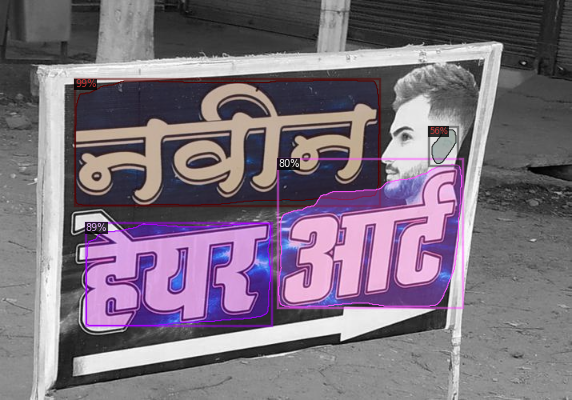

{'instances': Instances(num_instances=5, image_height=430, image_width=715, fields=[pred_boxes = Boxes(tensor([[297.7964, 131.5751, 421.4916, 195.7746],
        [434.2011, 150.3232, 547.5478, 193.6619],
        [266.7198, 258.0626, 575.1792, 314.6829],
        [267.4811, 260.9600, 404.7521, 306.7154],
        [ 76.6926, 128.7229, 118.9991, 172.9336]], device='cuda:0')), scores = tensor([0.9992, 0.9987, 0.9701, 0.9219, 0.7876], device='cuda:0'), pred_classes = tensor([0, 0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, F

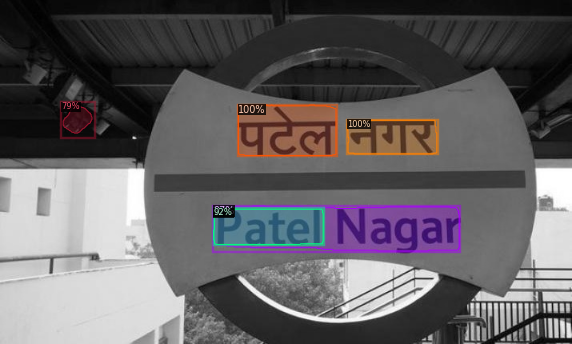

{'instances': Instances(num_instances=7, image_height=500, image_width=715, fields=[pred_boxes = Boxes(tensor([[512.4340, 368.8258, 615.5225, 421.3529],
        [118.4673, 338.6458, 280.4881, 418.5470],
        [286.2945, 361.9191, 386.2636, 417.2702],
        [392.2978, 348.0490, 501.8747, 436.0911],
        [381.0106, 482.8754, 408.1652, 495.2153],
        [  2.0873, 418.6844, 246.4278, 476.7143],
        [556.2237, 433.3460, 686.0970, 487.0929]], device='cuda:0')), scores = tensor([0.9991, 0.9975, 0.9972, 0.9785, 0.9706, 0.9589, 0.9384],
       device='cuda:0'), pred_classes = tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,

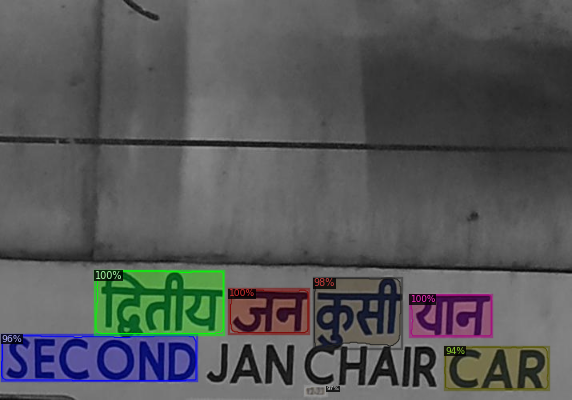

{'instances': Instances(num_instances=11, image_height=500, image_width=715, fields=[pred_boxes = Boxes(tensor([[416.2768, 321.0703, 567.3279, 367.7799],
        [517.0974, 389.8463, 580.8787, 427.7284],
        [336.0755, 382.8753, 512.9257, 426.5415],
        [379.3090, 447.5370, 542.2549, 480.8083],
        [592.3962, 397.9396, 649.5135, 428.0923],
        [447.3288, 281.3346, 477.2398, 292.3386],
        [309.7178, 313.0398, 407.5182, 369.6988],
        [500.1840, 282.6837, 543.2106, 298.8434],
        [543.7165, 437.3478, 607.1765, 481.9783],
        [577.1711, 310.6399, 684.7423, 378.8593],
        [480.0396, 277.1923, 499.0159, 294.4732]], device='cuda:0')), scores = tensor([0.9972, 0.9968, 0.9955, 0.9944, 0.9944, 0.9918, 0.9894, 0.9873, 0.9764,
        0.9730, 0.9346], device='cuda:0'), pred_classes = tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fal

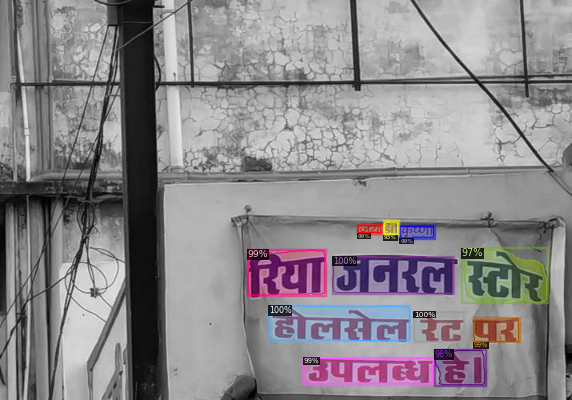

In [ ]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(test_dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=text_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("Hindi_Text_Recognition_testDataset1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "Hindi_Text_Recognition_testDataset1")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [01/13 04:14:43 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'Hindi_Text_Recognition_testDataset1'
[01/13 04:14:43 d2.data.datasets.coco]: Converting dataset annotations in 'Hindi_Text_Recognition_testDataset1' to COCO format ...)
[01/13 04:14:45 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/13 04:14:45 d2.data.datasets.coco]: Conversion finished, num images: 428, num annotations: 0
[01/13 04:14:45 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/Hindi_Text_Recognition_testDataset1_coco_format.json
[01/13 04:14:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    text    | 0            |
|            |              |
[01/13 04:14:48 d2.evaluation.evaluator]: Start inference on 428 images
[01/13 04:14:50 d2.evaluation.evaluator]: Inference done 11/428. 0.0987 s / img. ETA=0:01:37
[01/13 04:14:55 d2.evaluation.evaluator]: I

OrderedDict([('bbox',
              {'AP': -100.0,
               'AP50': -100.0,
               'AP75': -100.0,
               'APl': -100.0,
               'APm': -100.0,
               'APs': -100.0}),
             ('segm',
              {'AP': -100.0,
               'AP50': -100.0,
               'AP75': -100.0,
               'APl': -100.0,
               'APm': -100.0,
               'APs': -100.0})])

In [ ]:
from detectron2.modeling import build_model
model = build_model(cfg)
model_save_name = 'checkpoint.pth'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Hindi_Text_Recognition_trainingDataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0002  # pick a good LR
cfg.SOLVER.MAX_ITER = 14980    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (text)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
from detectron2.modeling import build_model
model = build_model(cfg)
model.load_state_dict(torch.load(path, map_location=device_gpu))

<All keys matched successfully>

# CRNN model

## Cropping Images for training ***CRNN*** model

In [ ]:
def gen_segment_pickles():
  d = {'image_ids':[], 'labels':[]}
  # occurance={}
  # train_sample_size=250000
  # val_sample_size = 10000
  # sample_size = train_sample_size + val_sample_size
  # folder = 'TrainSet'

  t = 0
  hh, ww = 50, 200
  for i in range(1,26):
    for image_path in os.listdir(train_data_path+'Image/'+str(i)+'/'):
      image = cv2.imread(train_data_path+'Image/'+str(i)+'/'+image_path)

      # grayscale
      #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      with open(train_data_path+'Annotation/'+str(i)+'/'+image_path[:-3]+'txt',mode='r') as f:
              ground_truth = f.read()
              ground_truth = list(ground_truth.split('\n'))
              #t += len(ground_truth)
              sorted_ctrs = []
              for anno in ground_truth:
                  anno = anno.split()
                  if(len(anno)!=9):
                    continue
                  px = anno[:4]
                  px=[float(x) for x in px]
                  py = anno[4:8]
                  py=[float(x) for x in py]
                  sorted_ctrs.append([np.min(np.abs(px)),np.min(np.abs(py)),np.max(np.abs(px)),np.max(np.abs(py)),anno[8]])
      for _, ctr in enumerate(sorted_ctrs):
          # Get bounding box
          x1, y1, x2, y2, true_label = ctr

          # Getting ROI
          roi = image[int(np.ceil(y1)):int(np.ceil(y2)), int(np.ceil(x1)):int(np.ceil(x2))]
          ht, wd, cc= roi.shape

          #reshapping the image to hh, ww size
          result = cv2.resize(roi, (ww, hh), interpolation = cv2.INTER_AREA)

          # if(t > train_sample_size and folder == 'TrainSet'):
          #   folder = 'ValSet'
          #   occurance = {}

          # if(true_label not in occurance):
          #   occurance[true_label]='1'
          #   os.makedirs(f'{folder}/{true_label}')
          # else:
          #   occurance[true_label]=str(int(occurance[true_label])+1)
          t += 1
          joblib.dump(result, f'/content/segment_pickles/{str(t).zfill(8)}.pkl')
          d['image_ids'].append(t)
          d['labels'].append(true_label)
  
  df = pd.DataFrame(d)
  return df

In [ ]:
df = gen_segment_pickles()

In [ ]:
df

image_ids   labels
0               1      कलम
1               2      रही
2               3       पर
3               4       वह
4               5      लोग
...           ...      ...
671328     671329       घर
671329     671330      बात
671330     671331       और
671331     671332  इतमीनान
671332     671333      कभी

[671333 rows x 2 columns]

In [ ]:
len(os.listdir('segment_pickles'))

671333

In [ ]:
train_df, val_df = train_test_split(df, test_size=.1, random_state=42, shuffle=True)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
train_df

image_ids  labels
0          130791   उत्सव
1            7837     कोई
2          297756     उसे
3          154077     रहे
4          590097      आप
...           ...     ...
604194     259179     साथ
604195     365839  कल्पना
604196     131933      अब
604197     671156  सन्तोष
604198     121959    बहुत

[604199 rows x 2 columns]

In [ ]:
val_df

image_ids labels
0         605674     अब
1         215317     पर
2         544365   उसके
3         236762    आगे
4         260068     और
...          ...    ...
67129     663765    हुए
67130     425550   अपना
67131      26556    अंग
67132      39055     वह
67133     217609     बच

[67134 rows x 2 columns]

In [ ]:
def get_train_transforms():
    return A.Compose(
        [
            # A.OneOf([
            #     A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
            #                          val_shift_limit=0.2, p=0.9),
            #     A.RandomBrightnessContrast(brightness_limit=0.2, 
            #                                contrast_limit=0.2, p=0.9),
            # ],p=0.9),
            A.ToGray(p=0.01),
            A.Resize(height=50, width=200, p=1),
            A.Normalize(),
            ToTensorV2(p=1.0)
        ], 
        p=1.0, 
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=50, width=200, p=1.0),
            A.Normalize(),
            ToTensorV2(p=1.0),
        ], 
        p=1.0
    )

In [ ]:
class DataLoader:
  def __init__(self, df, aug):
    self.image_ids = df['image_ids']
    self.labels = df['labels']

    self.aug = aug
  
  def __len__(self):
    return len(self.image_ids)
  
  def __getitem__(self, item):
    image = joblib.load(f'/content/segment_pickles/{str(self.image_ids[item]).zfill(8)}.pkl')
    image = Image.fromarray(image)
    image = self.aug(image = np.array(image))['image']
    #image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    return {'image':image,
            'label':self.labels[item]}

In [ ]:
class TestDataLoader:
  def __init__(self):
    self.aug = get_valid_transforms()

    self.image_ids = [i for i in enumerate(os.listdir('/content/cropped_data/cropped_dir'))]
    with open('/content/cropped_data/annotations.txt') as f:
      gt = f.read()
      gt = list(gt.split('\n'))
      gt = list(map(str.split, gt))
      label = []
      for i, anno in enumerate(gt):
        gts = [a for a in anno]
        if(len(gts)<2):
          continue
        label.append(gts[1])
    self.labels = label
  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, item):
    image = cv2.imread(f'/content/cropped_data/cropped_dir/{item}.jpg')
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = self.aug(image = np.array(image))['image']
    #image = np.transpose(image, (2, 0, 1))
    return {
        'image':image,
        'label':self.labels[item]
    }

In [ ]:
val_loader = DataLoader(val_df, get_valid_transforms())

In [ ]:
val_loader[5]

{'image': tensor([[[-1.1932, -1.1760, -1.1760,  ..., -1.4158, -1.3987, -1.3987],
          [-1.1932, -1.1418, -1.1418,  ..., -1.2959, -1.2788, -1.3130],
          [-1.1932, -1.1589, -1.1589,  ..., -1.1589, -1.1589, -1.2103],
          ...,
          [-0.8335, -0.8849, -0.9705,  ..., -1.0562, -1.0562, -1.0219],
          [-0.8335, -0.9363, -1.0219,  ..., -0.9020, -0.9192, -1.0048],
          [-0.8678, -0.9877, -1.0390,  ..., -0.7137, -0.7308, -0.9192]],
 
         [[-0.9678, -0.9153, -0.8627,  ..., -1.2479, -1.2479, -1.2654],
          [-0.9678, -0.9153, -0.8803,  ..., -1.1078, -1.1078, -1.1604],
          [-0.9678, -0.9153, -0.9153,  ..., -0.9503, -0.9503, -1.0203],
          ...,
          [-0.4601, -0.4776, -0.5476,  ..., -0.6352, -0.6527, -0.6176],
          [-0.4601, -0.4951, -0.5651,  ..., -0.4951, -0.5126, -0.6001],
          [-0.4951, -0.5476, -0.5826,  ..., -0.3025, -0.3200, -0.5126]],
 
         [[-0.0615,  0.0082,  0.0605,  ..., -0.3753, -0.3578, -0.4101],
          [-0.0615,

## Defining the CRNN model for image to text transformation

---
We are considering the image sizes to be 50 X 200


---



In [ ]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        resnet = resnet18(pretrained='imagenet')
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Loading the extracted segments of data into `torchvision.dataloader`

In [ ]:
train_dataset = DataLoader(train_df, get_train_transforms())

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

torch.Size([128, 3, 50, 200])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 50, 200])


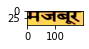

मजबूर


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next().values()

print(images.shape)
images.to(device_gpu)
print(images[1].shape)
npimg = images[1].numpy()
npimg = np.transpose(npimg, (1, 2, 0))
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()
print(labels[1])

## Setting up function to encode Hindi characters to numbers to feed into the model as ground truth

In [ ]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)
pad_char = '-'
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 110,

## Loss Function

In [ ]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [hindi_alpha2index[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits, criterion, device=device_gpu):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

## Training Function

In [51]:
def train(model, num_epochs, optimizer, train_loader, lr_scheduler, lr, weight_decay, val_loader = None):
  model.to(device_gpu)
  epoch_losses = []
  iteration_losses = []
  num_updates_epochs = []
  optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
  lr_scheduler = lr_scheduler(optimizer, verbose=True, patience=1)
  for epoch in tqdm(range(1, num_epochs + 1)):
      epoch_loss_list = [] 
      num_updates_epoch = 0
      model.train()
      for data in tqdm(train_loader, leave=False):
          image_batch = data['image']
          text_batch = data['label']

          optimizer.zero_grad()
          text_batch_logits = model(image_batch.to(device_gpu))
          loss = compute_loss(text_batch, text_batch_logits, nn.CTCLoss())
          iteration_loss = loss.item()

          if np.isnan(iteration_loss) or np.isinf(iteration_loss):
              continue
            
          num_updates_epoch += 1
          iteration_losses.append(iteration_loss)
          epoch_loss_list.append(iteration_loss)
          loss.backward()
          nn.utils.clip_grad_norm_(model.parameters(), 5)
          optimizer.step()

      epoch_loss = np.mean(epoch_loss_list)
      print("Epoch:{}    Training Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
      epoch_losses.append(epoch_loss)
      num_updates_epochs.append(num_updates_epoch)

      if val_loader is not None:
        model.eval()
        val_loss = []
        for data in tqdm(val_loader, leave=False):
          image_batch = data['image']
          text_batch = data['label']
          
          with torch.no_grad():
            text_batch_logits = model(image_batch.to(device_gpu))
            loss = compute_loss(text_batch, text_batch_logits, nn.CTCLoss())
            iteration_loss = loss.item()

          if np.isnan(iteration_loss) or np.isinf(iteration_loss):
              continue
          val_loss.append(iteration_loss)
        print("Epoch:{}    Validation Loss:{}".format(epoch, np.mean(val_loss)))
        lr_scheduler.step(np.mean(val_loss))

      else:
        lr_scheduler.step(epoch_loss)

  torch.save(model.state_dict(), f'/content/gdrive/My Drive/TransliterationDataset/checkpoint{num_epochs}.bin')

## Training the ***CRNN*** model

In [ ]:
model = CRNN(len(hindi_alpha2index))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
model.apply(weights_init)

CRNN(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
train(model=model, 
      num_epochs=10,
      optimizer=optim.Adam,
      lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau,
      lr=.001,
      weight_decay=1e-3,
      train_loader=train_loader)

Epoch:1    Loss:1.05493315610507    NumUpdates:4660


Epoch:2    Loss:0.6725611922822796    NumUpdates:4660


Epoch:3    Loss:0.6347762326130996    NumUpdates:4662


Epoch:4    Loss:0.6205969857980294    NumUpdates:4661


Epoch:5    Loss:0.6111192434258726    NumUpdates:4660


Epoch:6    Loss:0.6067118332877179    NumUpdates:4660


Epoch:7    Loss:0.6040363596808245    NumUpdates:4660


Epoch:8    Loss:0.6001674096949032    NumUpdates:4661


Epoch:9    Loss:0.5986450821436211    NumUpdates:4661


Epoch:10    Loss:0.5960553861546926    NumUpdates:4660



## Inference on test set

In [ ]:
index2hindi_alpha = {i:j for j, i in hindi_alpha2index.items()}

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.cpu().numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [index2hindi_alpha[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
testset = TestDataLoader()
test_loader = torch.utils.data.DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for data in tqdm(test_loader, leave=True):
        image_batch, text_batch = data['image'], data['label']
        text_batch_logits = model(image_batch.to(device_gpu)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [ ]:
results_test

actual  prediction
0          जल  ज--------क
1         शोध  श----ो---थ
2           न  र--------ा
3     संयंत्र  स--------े
4        बिना  द---िि-न-ा
...       ...         ...
1735       टी  स--------र
1736    स्टॉल  स--------ल
1737      एवं  ए-------वव
1738   नाश्ता  न-ा--श-तता
1739   कार्नर  क--रर-न--र

[1740 rows x 2 columns]

In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test

actual  prediction prediction_corrected
0          जल  ज--------क                   जक
1         शोध  श----ो---थ                  शोथ
2           न  र--------ा                   रा
3     संयंत्र  स--------े                   से
4        बिना  द---िि-न-ा                 दिना
...       ...         ...                  ...
1735       टी  स--------र                   सर
1736    स्टॉल  स--------ल                   सल
1737      एवं  ए-------वव                   एव
1738   नाश्ता  न-ा--श-तता                नाशता
1739   कार्नर  क--रर-न--र                 करनर

[1740 rows x 3 columns]

In [ ]:
results_test[results_test['prediction_corrected'] == results_test['actual']]

actual  prediction prediction_corrected
12      जिला  ज---ि---ला                 जिला
16      भारत  भ--ाा-र--त                 भारत
18      भारत  भ--ा--र--त                 भारत
19    अभियान  अ---भिय-ान               अभियान
25         न  ---------न                    न
...      ...         ...                  ...
1718    जाते  ज---ाा--ते                 जाते
1721   नासरे  न--ा--स-रे                नासरे
1725      सब  स--------ब                   सब
1727      सब  स--------ब                   सब
1734    बाबा  ब--ाा--ब-ा                 बाबा

[347 rows x 3 columns]

In [52]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/TransliterationDataset/checkpoint.bin'))

<All keys matched successfully>

In [ ]:
train(model=model, 
      num_epochs=10,
      optimizer=optim.Adam,
      lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau,
      lr=.001,
      weight_decay=1e-3,
      train_loader=train_loader,
      val_loader=torch.utils.data.DataLoader(val_loader, batch_size=64))

Epoch:1    Training Loss:0.5949571576880794    NumUpdates:4660


Epoch:1    Validation Loss:0.6345253608219912


Epoch:2    Training Loss:0.5922276316519537    NumUpdates:4661


Epoch:2    Validation Loss:0.6185413102070567


Epoch:3    Training Loss:0.5915929800515011    NumUpdates:4660


Epoch:3    Validation Loss:0.6368096982935111


Epoch:4    Training Loss:0.5902030258091734    NumUpdates:4660


Epoch:4    Validation Loss:0.6103616883252495


Epoch:5    Training Loss:0.5903964591192585    NumUpdates:4660


Epoch:5    Validation Loss:0.679125942761747


**Note:** Due to the constraints on the gpu compute provided I have to wait before I can resume training.

# Encoder - Decoder with Attention


---

Not yet finished

---



In [ ]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)